In [2]:
import numpy as np
import pandas as pd

import json
import torch
from torch import nn
from tqdm import tqdm
import faiss
import sqlite3
from transformers import BertModel, BertTokenizer

# For displaying thumbnail images
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [ ]:
product_df = pd.read_csv("labeled_beauty_products.csv")
product_df.head()

,id,title,description,label
0,B01ALT5MKW,Babo Botanicals Sheer Zinc Continuous Spray Su...,Get the comfort of a lotion sunscreen and the ...,13
1,B0C5Z7V77F,SUNATORIA Keratin Hair Mask - Professional Tre...,Restorative Hair Mask with Hydrolyzed Keratin ...,0
2,B0BZJ5LDZ6,[Farewell] Sunny I Tip Hair Extensions Natural...,SpecificationsSunny I tip hair extensions are ...,16
3,B09MTGTV3G,Vvan Long Straight Hair Ombre Green Straight W...,Basic information 1Hair MaterialHeat Resistant...,2
4,B0722JDG4Q,"Makeup Bag,Leather Double Layer Large Makeup O...",Durable Makeup Bag Travel Accessories for Wome...,47


In [ ]:
# Load in original data to add supplemental fields
file="meta_Beauty_and_Personal_Care.jsonl"

products = []

with open(file, 'r') as fp:
    for line in fp:
        products.append(json.loads(line.strip()))

In [ ]:
products[0]

{'main_category': 'All Beauty',
 'title': 'Shiyeen 10 Colors Hair Chalk for Girls Gift, Kids Temporary Bright Hair Color, Halloween Hair Chalk Comb Birthday Gift for Girls Of Ages 4 5 6 7 8 9 10+ Washable Non-Toxic for Kids Hair Dyeing Cosplay on Birthday Easter Party',
 'average_rating': 3.9,
 'rating_number': 57,
 'features': ['🌼[MEET YOUR HAIR COLOR NEEDS] Bright color, high-quality hair chalk. The comb applicators make it quick and easy to put dazzling colors into your hair. Your hair will be supple and natural, not stiff and sticky.',
  '🌼[Shiyeen COLORFUL HAIR CHALK COMBS SET] Contains White, purple, blue, orange, pink, red, cyan, green, brown, Rose ,10 bright colors, Disposable gloves, hair dye shawl.',
  '🌼[NON-TOXIC & EASY TO WASH] The hair chalk is non-allergenic , non-toxic and water-soluble and environmentally friendly ; apply it to hair evenly from top to bottom and washes out with ordinary shampoo and water.',
  '🌼[USING SIMPLE] The hair chalks are perfect for going wild!

In [ ]:
# APPEND NEW FIELDS TO DATA BY CREATING DICTIONARY WHERE KEYS ARE PARENT_ASIN AND VALUES ARE COLUMN VALUES
extra_product_info = {product['parent_asin']: [product['average_rating'], product['rating_number'], product['images'][0]['thumb'] if (len(product['images']) > 0) and ('thumb' in product['images'][0]) else '', product['store']] for product in products}

In [ ]:
extra_product_df = pd.DataFrame.from_dict(extra_product_info, orient="index")

In [ ]:
extra_product_df.columns = ['average_rating', 'number_of_ratings', 'thumbnail_image_link', 'store']

In [ ]:
extra_product_df.head()

,average_rating,number_of_ratings,thumbnail_image_link,store
B08BLDKYHB,3.9,57,https://m.media-amazon.com/images/I/51gOYWrMcr...,shiyeen
B0BWJGQ32Y,4.1,60,https://m.media-amazon.com/images/I/51F+qAS5nk...,Ebbfurln
B07DC9S9PF,4.4,7,https://m.media-amazon.com/images/I/41NOp1dKHu...,J-ANKKA
B0BM8WLSXF,4.0,68,https://m.media-amazon.com/images/I/512NLVN2JG...,CR8GR8
B00N4LMZZK,4.0,65,https://m.media-amazon.com/images/I/41agFEYjvb...,Cathy Doll


In [ ]:
product_df = product_df.set_index('id')

In [ ]:
final_df = product_df.join(extra_product_df)

In [ ]:
final_df.head()

,title,description,label,average_rating,number_of_ratings,thumbnail_image_link,store
id,,,,,,,
B01ALT5MKW,Babo Botanicals Sheer Zinc Continuous Spray Su...,Get the comfort of a lotion sunscreen and the ...,13,4.3,4526,https://m.media-amazon.com/images/I/31HroXkePf...,Babo Botanicals
B0C5Z7V77F,SUNATORIA Keratin Hair Mask - Professional Tre...,Restorative Hair Mask with Hydrolyzed Keratin ...,0,4.5,7102,https://m.media-amazon.com/images/I/419H3ghh2P...,SUNATORIA
B0BZJ5LDZ6,[Farewell] Sunny I Tip Hair Extensions Natural...,SpecificationsSunny I tip hair extensions are ...,16,4.3,2044,https://m.media-amazon.com/images/I/41KNez03bC...,Sunny Hair
B09MTGTV3G,Vvan Long Straight Hair Ombre Green Straight W...,Basic information 1Hair MaterialHeat Resistant...,2,4.3,3739,https://m.media-amazon.com/images/I/51eL-IlFi2...,TIMANZO
B0722JDG4Q,"Makeup Bag,Leather Double Layer Large Makeup O...",Durable Makeup Bag Travel Accessories for Wome...,47,4.6,2366,https://m.media-amazon.com/images/I/41PtJ3jmPL...,365park


In [ ]:
# Save final df
final_df.to_csv("C:/Users/benja/Desktop/Improving_Mp_Search/final_beauty_products_df.csv", index=True)

In [7]:
# In the future, we can now simply read in this data frame rather than reproducing it every time
final_df = pd.read_csv("final_beauty_products_df.csv", index_col='id')

In [8]:
final_df.head()

,title,description,label,average_rating,number_of_ratings,thumbnail_image_link,store
id,,,,,,,
B01ALT5MKW,Babo Botanicals Sheer Zinc Continuous Spray Su...,Get the comfort of a lotion sunscreen and the ...,13,4.3,4526,https://m.media-amazon.com/images/I/31HroXkePf...,Babo Botanicals
B0C5Z7V77F,SUNATORIA Keratin Hair Mask - Professional Tre...,Restorative Hair Mask with Hydrolyzed Keratin ...,0,4.5,7102,https://m.media-amazon.com/images/I/419H3ghh2P...,SUNATORIA
B0BZJ5LDZ6,[Farewell] Sunny I Tip Hair Extensions Natural...,SpecificationsSunny I tip hair extensions are ...,16,4.3,2044,https://m.media-amazon.com/images/I/41KNez03bC...,Sunny Hair
B09MTGTV3G,Vvan Long Straight Hair Ombre Green Straight W...,Basic information 1Hair MaterialHeat Resistant...,2,4.3,3739,https://m.media-amazon.com/images/I/51eL-IlFi2...,TIMANZO
B0722JDG4Q,"Makeup Bag,Leather Double Layer Large Makeup O...",Durable Makeup Bag Travel Accessories for Wome...,47,4.6,2366,https://m.media-amazon.com/images/I/41PtJ3jmPL...,365park


Let's try testing our model with only the products that were successfully classified by BerTopic.

In [9]:
final_df = final_df.loc[final_df['label'] != -1]

In [10]:
class QueryEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use fewer transformer layers for queries since they're shorter
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=2,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)

    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)

        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use mean pooling instead of CLS token for queries
        # This helps capture information from all tokens in short queries
        mask_expanded = attention_mask.unsqueeze(-1).expand(x.size())
        sum_embeddings = torch.sum(x * mask_expanded, 1)
        sum_mask = torch.sum(mask_expanded, 1)
        mean_embeddings = sum_embeddings / sum_mask
        return self.projection(mean_embeddings)

In [11]:
class ProductEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use more transformer layers for product descriptions since they're longer
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=4,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)

    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)

        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use CLS token for product descriptions
        cls_embed = x[:,0,:]
        return self.projection(cls_embed)

In [12]:
final_df.head()

,title,description,label,average_rating,number_of_ratings,thumbnail_image_link,store
id,,,,,,,
B01ALT5MKW,Babo Botanicals Sheer Zinc Continuous Spray Su...,Get the comfort of a lotion sunscreen and the ...,13,4.3,4526,https://m.media-amazon.com/images/I/31HroXkePf...,Babo Botanicals
B0C5Z7V77F,SUNATORIA Keratin Hair Mask - Professional Tre...,Restorative Hair Mask with Hydrolyzed Keratin ...,0,4.5,7102,https://m.media-amazon.com/images/I/419H3ghh2P...,SUNATORIA
B0BZJ5LDZ6,[Farewell] Sunny I Tip Hair Extensions Natural...,SpecificationsSunny I tip hair extensions are ...,16,4.3,2044,https://m.media-amazon.com/images/I/41KNez03bC...,Sunny Hair
B09MTGTV3G,Vvan Long Straight Hair Ombre Green Straight W...,Basic information 1Hair MaterialHeat Resistant...,2,4.3,3739,https://m.media-amazon.com/images/I/51eL-IlFi2...,TIMANZO
B0722JDG4Q,"Makeup Bag,Leather Double Layer Large Makeup O...",Durable Makeup Bag Travel Accessories for Wome...,47,4.6,2366,https://m.media-amazon.com/images/I/41PtJ3jmPL...,365park


In [16]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

query_encoder = QueryEncoder(vocab_size=tokenizer.vocab_size, embed_dim=512, output_embed_dim=128)
query_encoder.load_state_dict(torch.load("beauty_products_query_encoder_v3.pt"))

description_encoder = ProductEncoder(vocab_size=tokenizer.vocab_size, embed_dim=512, output_embed_dim=128)
description_encoder.load_state_dict(torch.load("beauty_products_description_encoder_v3.pt"))

<ipython-input-16-f746901eea6d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  query_encoder.load_state_dict(torch.load("beauty_products_query_encoder_v3.pt"))
<ipython-in

<All keys matched successfully>

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
product_descriptions = list(final_df['description'])
product_ids = list(final_df.index)
batch_size=128
description_encoder = description_encoder.to(device)

sample_tokens = tokenizer(
    product_descriptions[0:1],
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
)

with torch.no_grad():
    sample_embedding = description_encoder(sample_tokens)
embedding_dim = sample_embedding.shape[1]

# Create FAISS index based on requested type
index = faiss.IndexFlatIP(embedding_dim)

# Encode all products in batches and add to index
print("Encoding products and adding to index...")
batch_product_ids = []

# Create batches for product descriptions
batches = [product_descriptions[i:i + batch_size] for i in range(0, len(product_descriptions), batch_size)]
batch_ids = [product_ids[i:i + batch_size] for i in range(0, len(product_ids), batch_size)]

for batch_desc, batch_id in tqdm(zip(batches, batch_ids), total=len(batches), desc="Building index"):
    tokens = tokenizer(
        batch_desc,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512
    )

    # Encode batch
    with torch.no_grad():
        embeddings = description_encoder(tokens)
        # Normalize embeddings for cosine similarity
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

    # Add to index
    index.add(embeddings.cpu().numpy())
    batch_product_ids.extend(batch_id)

print(f"Index built with {len(batch_product_ids)} products")

Encoding products and adding to index...


Building index: 100%|██████████| 117/117 [02:25<00:00,  1.25s/it]

Index built with 14972 products


In [19]:
from google.colab import files
faiss.write_index(index, "beauty_product_embeddings_v3.index")
files.download("beauty_product_embeddings_v3.index")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Create SQL Connection
conn = sqlite3.connect("beauty_product_embeddings.db")
cursor = conn.cursor()

In [21]:
# CREATE SQL TABLE
cursor.execute("DROP TABLE IF EXISTS products")

cursor.execute("""
    CREATE TABLE products (
        id TEXT PRIMARY KEY,
        product_name TEXT,
        seller TEXT,
        product_description TEXT,
        num_ratings INTEGER,
        avg_rating REAL,
        image_link TEXT
    )
    """)
conn.commit()

# POPULATE SQL TABLE WITH PRODUCT DATA
for row in final_df.itertuples(index=True, name=None):
    prod_id, prod_name, prod_desc, _, avg_rating, num_rating, image_url, store = row
    cursor.execute(
        """INSERT OR REPLACE INTO products
        (id, product_name, seller, product_description, num_ratings, avg_rating, image_link) VALUES (?, ?, ?, ?, ?, ?, ?)""",
        (prod_id, prod_name, store, prod_desc, num_rating, avg_rating, image_url)
    )
conn.commit()

In [22]:
res = cursor.execute("SELECT * FROM products LIMIT 1")
res.fetchall()

[('B01ALT5MKW',
  'Babo Botanicals Sheer Zinc Continuous Spray Sunscreen SPF 30 with 100% Mineral Active, Water-Resistant, Fragrance-Free, Vegan, for Babies, Kids or Sensitive Skin - 6 Oz. - 1-Pack',
  'Babo Botanicals',
  'Get the comfort of a lotion sunscreen and the convenience of a continuous spray for the entire family The Sheer Zinc Sunscreen Spray SPF 30 uses Zinc Oxide as the physical filter that forms a protective barrier on skin surface to help reflect the suns UVA and UVB rays without irritating sensitive skin This easy to apply formula is enriched with aloe vera and sunflower oil to soothe and moisturize Provides 80 minutes of water resistance Hold the bottle 812 inches away and spray onto skin Thoroughly rub in until the white lotion blends into skin For increased control spray onto palm of hand and apply into skin Fragrance Free and perfect for the entire family 100 GOOD FOR YOU  YOUR FAMILY A fastabsorbing ultrasheer  lightweight sunblock for delicate skin Water resistan

In [23]:
def search(query, product_embeddings, k=10):
    query_tokens = tokenizer(
        query,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=32
    )

    with torch.no_grad():
        query_embedding = query_encoder(query_tokens)
        query_embedding = torch.nn.functional.normalize(query_embedding, p=2, dim=1)

    similarities, indices = product_embeddings.search(query_embedding.cpu().numpy(), k)

    similarities = similarities.reshape(-1)
    indices = indices.reshape(-1)
    top_product_ids = list(final_df.index[indices])

    placeholders = ', '.join(['?'] * len(top_product_ids))
    query = f"SELECT id, product_name, product_description, seller, image_link FROM products WHERE id IN ({placeholders})"
    res = cursor.execute(query, top_product_ids)
    query_results = res.fetchall()

    results = [{
        'product_id': query_result[0],
        'product_name': query_result[1],
        'product_description': query_result[2],
        'seller': query_result[3],
        'image_url': query_result[4],
        'similarity_score': similarity
    } for query_result, similarity in zip(query_results, similarities)]

    return results

In [24]:
# Read in index
index = faiss.read_index("beauty_product_embeddings_v3.index")

In [41]:
search_results = search("dermatologist approved wash", index)

In [42]:
print(f"Number of items in index: {index.ntotal}")

Number of items in index: 14972


In [43]:
print(f"Total search results: {len(search_results)}")
print(search_results[:3])  # Print first 3 items to inspect

Total search results: 10
[{'product_id': 'B0018ZRTZA', 'product_name': 'Skin Obsession 40% Glycolic Acid Peel for Acne, Scars, Age Spots & Lines', 'product_description': 'Glycolic Acid has long been a first line product of the finest spas and Dermatology offices for improving the skin For those of you who have heard the term Lunch Time Peel this is the chemical used for it Now you can do these peels at home safely and with fantastic results After peeling your skin will be feel softer look smoother with improved texture and tone and reduced hyperpigmentation sun damage With a peel of this strength a full course of peels 810 peels are needed to see optimal results This is a 1 fl oz 30 ml of peel solution Glycolic Acid is a naturally occurring chemical belonging to the Alpha Hydroxy Acid AHA family Derived from sugar cane this important AHA is the smallest of the fruit acids and is able to penetrate the skin allowing it to effectively dissolve the glue that holds dead cells on the surface

Product Name: Skin Obsession 40% Glycolic Acid Peel for Acne, Scars, Age Spots & Lines
Product Description: Glycolic Acid has long been a first line product of the finest spas and Dermatology offices for improving the skin For those of you who have heard the term Lunch Time Peel this is the chemical used for it Now you can do these peels at home safely and with fantastic results After peeling your skin will be feel softer look smoother with improved texture and tone and reduced hyperpigmentation sun damage With a peel of this strength a full course of peels 810 peels are needed to see optimal results 


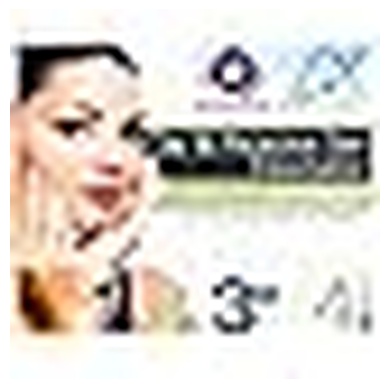

Product Name: Acne Free 3-Step Acne Treatment Kit with Salicylic Acid Face Wash, Alcohol-Free Toner, & Benzoyl Peroxide Lotion for Sensitive Skin and Fighting Breakouts, 24 Hour Face Clearing System
Product Description: 60 DAY SUPPLY OF ACNEFREE THE 1 ACNE KIT SOLD IN STORES  Each AcneFree Kit provides you with products that will help treat your acne while taking care of your skin for 2 months Compare and save money as opposed to competing brands 3 SIMPLE STEPS FOR A COMPLETE SKINCARE ROUTINE 1 Cleanse your face with the 15 Salicylic Acid Acne Face Wash to gently cleanse clogged pores and remove acne bacteria2 Tone with the AlcoholFree Toner infused with fruit enzymes to balance skin 3 Moisturize with the Sensi


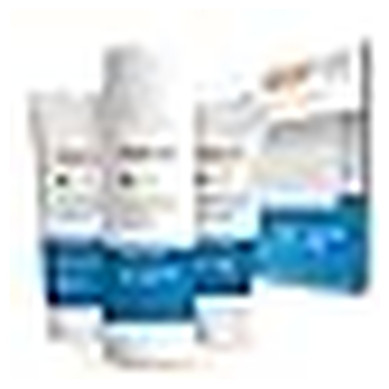

Product Name: Burt's Bees Natural Acne Solutions Pore Refining Cleansing Scrub, Exfoliating Face Wash for Oily Skin, 4 Oz (Package May Vary)
Product Description: Refine the appearance of pores and prevent future breakouts with Burts Bees Natural Acne Solutions Pore Refining Scrub Its clinically shown to exfoliate dead skin cells while refining the appearance of pores This 990 natural formula contains jojoba beads and a natural fruit acid complex for gentle exfoliation without overdrying or irritating skin Also formulated with salicylic acid derived naturally from willow bark to penetrate clogged pores reduce acne and help prevent future breakouts For bes


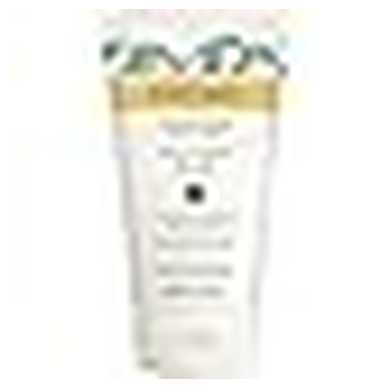

Product Name: Neutrogena Rapid Clear Foaming Exfoliating Facial Scrub with Salicylic Acid Acne Medicine For Breakouts and Acne-Prone Skin, 4.2 fl. oz
Product Description: Product Description Clear breakouts while gently exfoliating your skin with Neutrogena Rapid Clear Foaming Exfoliating Facial Scrub Designed for acneprone skin this scrub instantly breaks down poreclogging oil visibly reduces breakouts and helps prevent new ones from emerging Clinically proven MicroClear Technology boosts the delivery of salicylic acid acne medicine deep into congested pores With gentle exfoliators this face scrub sweeps away dead skin cells to smooth skin and prevent overdrying


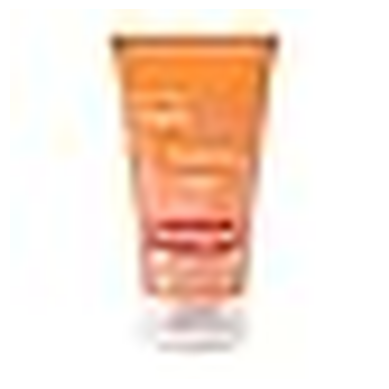

Product Name: BIOAQUA Acne Scar Natural Blemish Gel Acne Pimple Acne Spot Removal Cream, Oil Control Shrink Pores Face Care Cream
Product Description: Type Moisturizer acne scar removal Apply Area Face Features Get rid of acne acne marks and repairing damage to the skin Essence of this gel can shrink pores improve elasticity of skin Effectively adjust and balance facial oil secretion on your face skin Keep applying this cream to keep the face clean and fresh Anti Acne Cream  Oil Control  Shrink Pores Acne Scar Remove Face Care Usage1 First to clean the skin 2 Take the appropriate amount of product evenly smear sites for acne 3 Last to gently m


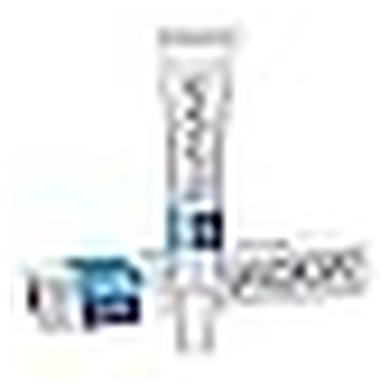

Product Name: Open Formula Glycolic Acid 20% Peel Serum. Only 2 Ingredients. Best Chemical Peel To Exfoliate Your Skin, For Resurfacing Fine Lines & Wrinkles, Brightening Acne Scars, Anti Aging Dark Spot Corrector
Product Description: NEW LOOK New design same great procut  THE BENEFITS It adds a healthy glow Exfoliates dead skin cells to expose newer better looking skin on your face  KEY INGREDIENTS 20 glycolic acid offers immediate exfoliation It breaks the bond holding dead skin cells together to remove them from your face  WHAT IT DOES Improves uneven skin tone and dull complexion Reduces the appearance of dark spots and hyperpigmentation  SKIN TYPES Can be used by all skin types  dry sensitive oily normal combination Work


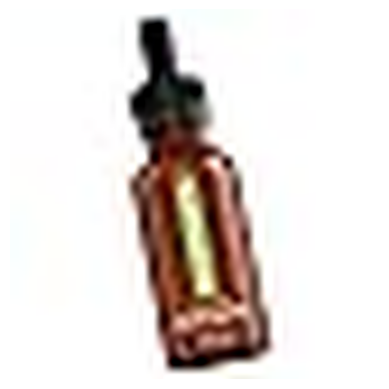

Product Name: Venanoci Green Tea Mask stick, Purifying Clay Mask, Blackhead Remover,Poreless Deep Cleanse Mask Stick,Oil Control Face Mask, Skin Detoxifying Face Stick Mask for all Skin Types (Green Tea)
Product Description: White Charcoal Formulated with white charcoal  Kaolin clay to remove the buildup of dead skin cells to bring fresh ones to the surface Moisturize  SoftenBrighten Green tea mask stick penetrate deep within your pores to absorb excess oil and give your skin a deep gentle cleanse that it deserves In addition to cleansingGreen tea mask stick softens and brightens your skin with rich hydration Green Tea Clay Mask This green tea clay facial mask contains powerful green tea extract and plant essence th


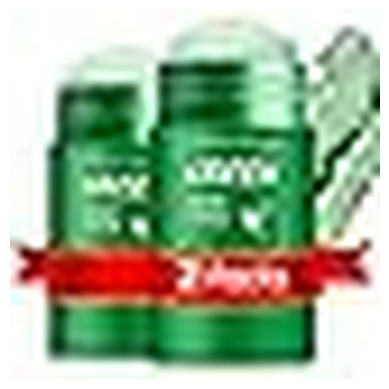

Product Name: Asepxia Deep Cleansing Acne Treatment Bar Soap with Baking Soda and 2% Salicylic Acid, 4 Ounce
Product Description: A bar soap that deeply cleans dirt and oil from pores  fights imperfections With Baking Soda  Salicylic Acid  Hydro Force Formula Leaves skin smooth  moisturized Cleansing Acne Bar Soap This soap gives your skin deep cleansing for acne prone skin washing away dirt and oil moisturizing and exfoliating to help fight acne Gentle Formula This soap helps fight acne while cleansing skin with our advanced Hydro Force formula plus salicylic acid and baking soda for smooth fresh hydrated skin Cleansing P


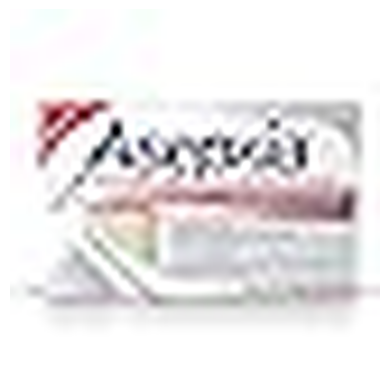

Product Name: Skin Scrubber Skin Spatula Blackhead Remover Pore Cleaner Face Beauty Lifting Tool Comedones Extractor Facial Cleaner for Deep Cleansing with 2 Silicone Case
Product Description: DEEP CLEANSING FACIALThis skin scrubber uses a waterbased exfoliation technology that must be used on wet skinIt can clean blackheads whiteheads keratin dead skin acne The skin can be deeply cleaned 4 FUNCTIONAL MODESDeep clean skin make the skin clean and fresh Liftinglifts and tightens the skin remove the deep wrinkleIonWill help remove blackheads dead skin oil and dirt from your faceIonHelps skin absorb nutrition from skin care products quickly FACIAL SKIN SCRUBBERThe spatula has a rounded Ra


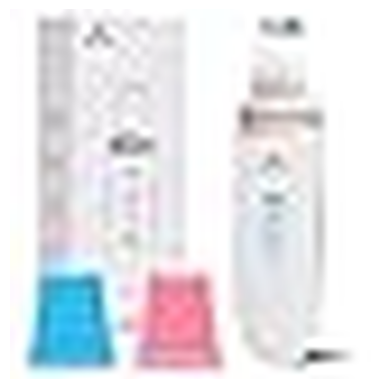

Product Name: Nip + Fab Salicylic Acid Fix Day Pads for Face with Aloe Vera, Exfoliating Facial Pad BHA Exfoliant for Skin Hydration Acne Breakouts Refining Pores Oil Control, 60 Pads, 2.7 Ounce
Product Description: Nip  Fab Salicylic Fix Day Pads Reduce shine and decongest skin with our Salicylic Fix Day Face Pads The powerhouse ingredient behind blemishfree skin these exfoliating salicylic acid pads with aloe vera and Egyptian and Asian lotus flower extracts are formulated to prevent acne and stop breakouts in their tracks They gently exfoliate and deeply cleanse the skin refining pores combating blackheads and preventing future breakouts while soothing and hydrating skin The ultimate bha exfoliator salic


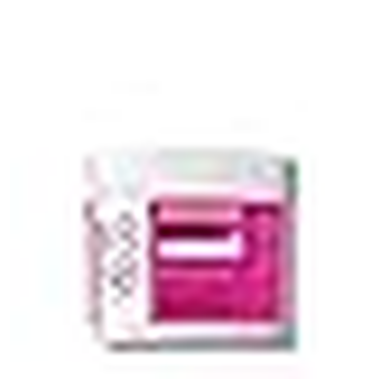

In [44]:
for result in search_results:
    try:
        # URL of the image
        image_url = result['image_url']

        # Fetch the image
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))

        target_size = (1000, 1000)

        # Calculate the aspect ratio
        img_ratio = img.width / img.height
        target_ratio = target_size[0] / target_size[1]

        if img_ratio > target_ratio:
            # Scale based on width
            new_width = target_size[0]
            new_height = int(new_width / img_ratio)
        else:
            # Scale based on height
            new_height = target_size[1]
            new_width = int(new_height * img_ratio)

        # Resize the image while maintaining the aspect ratio
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)

        print(f"Product Name: {result['product_name']}")
        print(f"Product Description: {result['product_description'][:500]}")
        # Display the resized image
        plt.imshow(img_resized)
        plt.axis('off')  # Hide the axes
        plt.show()
    except:
        print(f"Product Name: {result['product_name']}")
        print(f"Product Description: {result['product_description'][:500]}")
        print("No product image provided")